In [4]:
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import urllib.request
import os
from google_patent_scraper import scraper_class
import json
import timeit
import networkx as nx
import matplotlib.pyplot as plt

## Loading patents

In [7]:
ids = pd.read_csv(r"../data/gp-q2-7topics.csv",index_col='code',skipinitialspace=True)
print(ids.isnull().sum())
ids 

Unnamed: 0            0
title                 0
pub_date              0
citations             0
abstract              0
class                 0
year                  0
abstract_processed    0
topic                 0
dtype: int64


,Unnamed: 0,title,pub_date,citations,abstract,class,year,abstract_processed,topic
code,,,,,,,,,
US8370262B2,0,System and method for performing secure online...,2013-02-05,"['US10681025B2', 'CN106664208B', 'AU2012261635...",\nThe system and method performing secure onli...,G06,2013,\nthe system and method performing secure onli...,4
US10237070B2,1,System and method for sharing keys across auth...,2019-03-19,"['US10268809B2', 'JP6538821B2', 'KR101721032B1...","\nA system, apparatus, method, and machine rea...",H04,2019,\na system apparatus method and machine readab...,4
US10637853B2,2,Authentication techniques including speech and...,2020-04-28,"['US10706421B2', 'US20160269411A1', 'US1021258...","\nA system, apparatus, method, and machine rea...",H04,2020,\na system apparatus method and machine readab...,4
US10558974B2,3,Methods and systems of providing verification ...,2020-02-11,"['US20190149537A1', 'US20180308098A1', 'US2018...",\nA method and system of providing verificatio...,G06,2020,\na method and system of providing verificatio...,4
US10769635B2,4,Authentication techniques including speech and...,2020-09-08,"['US9531710B2', 'US10706421B2', 'US20160269411...","\nA system, apparatus, method, and machine rea...",G06,2020,\na system apparatus method and machine readab...,1
...,...,...,...,...,...,...,...,...,...
KR100477956B1,9471,System and method for filtering message edited...,2005-03-23,"['US9501746B2', 'US10110519B2', 'US7133898B1',...",\r\nA method and system for filtering a messag...,H04,2005,\r\na method and system for filtering a messag...,6
FR3092468A1,9472,Secure registration and building control system,2020-08-07,"['US20150173255A1', 'US10147307B2', 'US9135807...",\r\n \r\n \r\n [Systme denregis...,H04,2020,\r\n \r\n \r\n [systme denregis...,0
CN105723378B,9473,Protection system including safety regulation ...,2019-06-18,"['JP2017034696A', 'CN107852410B', 'CN105210042...",\nThis disclosure relates to a kind of protect...,H04,2019,\nthis disclosure relates to a kind of protect...,3


In [8]:
ids['class'].value_counts()

G06    4726
H04    3304
NAN     621
G08     153
G07     125
G01      90
G05      70
G10      58
G16      43
G09      41
B60      35
A61      33
A63      30
G11      21
B64      20
B25       9
Y02       8
B65       8
F41       7
B42       6
H01       6
H05       5
A47       5
A01       5
B61       4
H02       4
B07       3
A62       3
E05       2
C12       2
C07       2
B67       2
A41       2
F24       2
E01       1
G21       1
B66       1
E04       1
B63       1
A45       1
B01       1
B22       1
C11       1
Y04       1
H03       1
F21       1
C02       1
A23       1
G02       1
F03       1
F02       1
C09       1
B62       1
B29       1
F16       1
Name: class, dtype: int64

ids = ids[ids.abstract.notna()]
#ids = ids[ids['class'].notna()]
ids = ids[ids['citations']!='[]']
ids['class'] = ids['class'].astype('str').apply(lambda x: x[:4] if len(x) >= 3 else 'NAN')
print(ids.isnull().sum())


In [12]:
ids['class'] = [cl if cl=='G06' or cl=='H04' else 'other' for cl in ids['class']  ]
ids['class'].value_counts()

G06      4726
H04      3304
other    1446
Name: class, dtype: int64

In [13]:
ids['class_topic'] = [ cl + '_' + str(topic) for (cl,topic) in ids[['class','topic']].values]
pd.crosstab(ids['class'],ids['topic'])

topic,0,1,2,3,4,5,6
class,,,,,,,
G06,696,480,391,770,897,958,534
H04,406,249,252,293,689,1107,308
other,119,99,146,700,88,227,67


## Building the network

In [14]:
G = nx.Graph()

for code, patent in ids.iterrows():
    patent['class_topic'] = patent['class'] + '_' + str(patent['topic'])
    if patent['citations'] != '[]': #citation is a string represetnation of a list 
        for l in str(patent['citations'][1:-1]).split(','):
            link = l.replace(" ","")[1:-1]
            if link in ids.index and link!=code: 
                G.add_edge(code, str(link) )

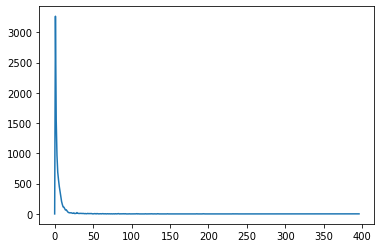

density:  0.0006411086026523331
average clustering coefficient:  0.10546879732181237


In [15]:
plt.plot(nx.degree_histogram(G))
plt.show()
print('density: ', nx.density(G))
print('average clustering coefficient: ', nx.average_clustering(G))

In [16]:
ids['class']=ids['class'].astype('str')

nx.set_node_attributes(G, 'NA', name='class')
for node in ids.index:
    nx.set_node_attributes(G, {node: str(ids.loc[node,'class'])}, name='class')
    nx.set_node_attributes(G, {node: str(ids.loc[node,'topic'])}, name='topic')
    nx.set_node_attributes(G, {node: str(ids.loc[node,'class_topic'])}, name='class_topic')
                           
print('number of nodes: ', len(G.nodes))
pd.Series( [G.nodes[node]['class_topic'] for node in G.nodes]).value_counts()

number of nodes:  9476


H04_5      1107
G06_5       958
G06_4       897
G06_3       770
other_3     700
G06_0       696
H04_4       689
G06_6       534
G06_1       480
H04_0       406
G06_2       391
H04_6       308
H04_3       293
H04_2       252
H04_1       249
other_5     227
other_2     146
other_0     119
other_1      99
other_4      88
other_6      67
dtype: int64

In [17]:
nx.write_graphml(G, "../data/7topics.graphml")

# Components

In [52]:
G = nx.read_graphml("../data/7topics.graphml") #when reading you should change the attibute names
components =  [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
avg_size = np.average([len(c) for c in components])
print('average componets size: ', avg_size)


average componets size:  24.359897172236504


In [54]:
Large = components[0]
mediums = [c for c in components[1:] if len(c) >= avg_size]
smalls = [c for c in components[1:] if len(c) < avg_size]

print(len(Large),nx.average_clustering(G,Large))
for c in mediums: print(len(c),nx.average_clustering(G,c))

8104 0.113687078315134
120 0.5639412318862845
68 0.020647653000594176
45 0.0


In [31]:
len(components)

389

In [30]:
len(np.bincount([len(c) for c in components]))

8105

In [20]:
components =  [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
for c in components:
    if len(c) < 4 or nx.average_clustering(G,c)==0 : G.remove_nodes_from(c)
components =  [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
for c in components: print(len(c),nx.average_clustering(G,c))

8104 0.113687078315134
120 0.5639412318862845
68 0.020647653000594176
17 0.08972073677956031
8 0.175
7 0.3
5 0.3333333333333333
4 0.5833333333333333


In [69]:
for c in components:
    print(ids.loc[c,'topic'].value_counts())

7    2185
0    1899
2     982
4     854
6     664
1     638
3     561
5     312
Name: topic, dtype: int64
7    81
4    21
2    11
3     7
Name: topic, dtype: int64
7    32
2    22
3     9
6     2
0     2
5     1
Name: topic, dtype: int64
7    8
2    7
4    1
3    1
Name: topic, dtype: int64
2    5
4    2
5    1
Name: topic, dtype: int64
3    6
1    1
Name: topic, dtype: int64
0    5
Name: topic, dtype: int64
5    3
3    1
Name: topic, dtype: int64


In [205]:
for c in components[1:]:
    G.remove_nodes_from(c)



In [119]:
print(len([G.nodes[node] for node in G.nodes ]),len([node for node in G.nodes if G.nodes[node]['topic']!='7']))

8095 5910


In [206]:
G.remove_nodes_from([node for node in G.nodes if G.nodes[node]['topic']!='7'])

1198 0.26506303720786545


In [215]:
remove = [node for node,degree in dict(G.degree()).items() if degree < 19 and node in components[0]]
G.remove_nodes_from(remove)
components =  [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
for c in components: print(len(c),nx.average_clustering(G,c))

7 0.7095238095238096
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0
1 0.0


In [102]:
print(nx.average_degree(G))

AttributeError: module 'networkx' has no attribute 'average_degree'

In [136]:
comp = nx.connected_components(G)

In [138]:
for i in comp: print(i)

{'US9838407B1', 'US10412074B2', 'US20140365281A1', 'US10567411B2', 'US8418249B1', 'US10728277B2', 'US10257127B2', 'US8201255B1', 'US20190188392A1', 'AU2011342282B2', 'US10474448B2', 'US10705821B2', 'KR101815514B1', 'US9158915B1', 'US10817569B2', 'US10771464B2', 'US20200265139A1', 'US20200137021A1', 'JP2018201235A', 'US10860618B2', 'US10686827B2', 'JP2020195141A', 'US10509898B2', 'US20180260106A1', 'US20200287807A1', 'CN106778266A', 'CN102754104A', 'US20180007069A1', 'US20180212985A1', 'US10891318B2', 'CN107567628B', 'US10750360B2', 'WO2020168614A1', 'US9921574B1', 'US9229977B2', 'US9866584B2', 'US10764252B2', 'US7894634B2', 'US20190272375A1', 'US8266051B2', 'US9594886B2', 'US8826434B2', 'US10061807B2', 'US10079843B2', 'US8464343B1', 'WO2006128124A2', 'KR102203562B1', 'US20180232904A1', 'US20200372018A1', 'CN101026802B', 'CN110602041A', 'US20180205755A1', 'EP1879124A1', 'KR20170081386A', 'CN103761481A', 'US10693758B2', 'US20170235954A1', 'KR20200131701A', 'US20070197261A1', 'US202000347

In [141]:
 for c in sorted(nx.connected_components(G), key=len, reverse=True): print(len(c),end=' ')

3133 120 22 21 20 19 17 16 12 12 11 11 11 10 9 8 8 7 7 7 7 7 6 6 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

In [171]:
ids['label'] = [0 for i in ids.index]
for i,c in enumerate(sorted(nx.connected_components(G), key=len, reverse=True)):
    for code in c:
        ids.loc[code,'label'] = i+1
        
ids.label.value_counts()

0      3167
1      3133
2       120
3        22
4        21
       ... 
94        2
90        2
86        2
187       2
193       2
Name: label, Length: 195, dtype: int64

In [158]:
remove = [node for node in ids.index if ids.loc[node,'label']>2 or ids.loc[node,'label']==0 ]
G.remove_nodes_from(remove)

remove = [node for node,degree in dict(G.degree()).items() if degree < 7]
G.remove_nodes_from(remove)

# CORES

In [224]:
G = nx.read_graphml("test.graphml") 
[G.nodes[node] for node in G.nodes]


[{'class': 'G06', 'topic': '4', 'class_topic': 'G06_4'},
 {'class': 'H04', 'topic': '4', 'class_topic': 'H04_4'},
 {'class': 'H04', 'topic': '4', 'class_topic': 'H04_4'},
 {'class': 'G06', 'topic': '4', 'class_topic': 'G06_4'},
 {'class': 'G06', 'topic': '2', 'class_topic': 'G06_2'},
 {'class': 'H04', 'topic': '4', 'class_topic': 'H04_4'},
 {'class': 'G06', 'topic': '6', 'class_topic': 'G06_6'},
 {'class': 'G06', 'topic': '7', 'class_topic': 'G06_7'},
 {'class': 'G06', 'topic': '1', 'class_topic': 'G06_1'},
 {'class': 'H04', 'topic': '0', 'class_topic': 'H04_0'},
 {'class': 'H04', 'topic': '1', 'class_topic': 'H04_1'},
 {'class': 'H04', 'topic': '0', 'class_topic': 'H04_0'},
 {'class': 'G06', 'topic': '4', 'class_topic': 'G06_4'},
 {'class': 'G06', 'topic': '4', 'class_topic': 'G06_4'},
 {'class': 'G06', 'topic': '6', 'class_topic': 'G06_6'},
 {'class': 'G06', 'topic': '6', 'class_topic': 'G06_6'},
 {'class': 'G06', 'topic': '6', 'class_topic': 'G06_6'},
 {'class': 'G06', 'topic': '2',

In [226]:
print(nx.core_number(G)['US20190364019A1'])

8


In [229]:
cores = nx.core_number(G)
for node in G.nodes:
     nx.set_node_attributes(G, {node: cores[node]}, name='cores')

In [234]:
for node in G.nodes:
     nx.set_node_attributes(G, {node: cores[node]}, name='cores')

In [235]:
nx.write_graphml(G, "10cores.graphml")

In [233]:
[cores[node] for node in G.nodes]

[5,
 6,
 6,
 5,
 6,
 6,
 1,
 3,
 3,
 9,
 6,
 6,
 2,
 2,
 1,
 1,
 4,
 7,
 3,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 2,
 1,
 1,
 8,
 8,
 8,
 8,
 4,
 8,
 8,
 8,
 8,
 8,
 6,
 8,
 8,
 8,
 8,
 8,
 2,
 2,
 1,
 4,
 1,
 2,
 2,
 8,
 10,
 10,
 15,
 15,
 15,
 7,
 15,
 15,
 15,
 15,
 15,
 15,
 1,
 6,
 2,
 5,
 8,
 1,
 1,
 2,
 2,
 2,
 2,
 4,
 4,
 1,
 1,
 8,
 8,
 8,
 8,
 8,
 8,
 2,
 1,
 8,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 3,
 5,
 5,
 5,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 5,
 3,
 5,
 6,
 6,
 6,
 2,
 4,
 4,
 2,
 4,
 4,
 4,
 8,
 4,
 4,
 4,
 8,
 1,
 7,
 8,
 7,
 8,
 2,
 1,
 2,
 2,
 6,
 6,
 11,
 1,
 2,
 2,
 2,
 2,
 6,
 5,
 8,
 5,
 8,
 8,
 2,
 2,
 2,
 1,
 3,
 6,
 6,
 1,
 1,
 1,
 2,
 3,
 9,
 7,
 5,
 8,
 4,
 8,
 8,
 6,
 11,
 11,
 12,
 11,
 8,
 11,
 1,
 4,
 5,
 2,
 4,
 4,
 1,
 1,
 2,
 1,
 7,
 1,
 1,
 1,
 2,
 14,
 2,
 1,
 4,
 5,
 1,
 4,
 9,
 7,
 2,
 1,
 4,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 6,
 2,
 5,
 8,
 1,
 4,
 4,
 4,
 6,
 2,
 8,
 7,
 8,
 5,
 3,
 11,
 1,
 1,
 3,
 

## Nodes CLASSIFICATION

In [239]:
clf=nx.node_classification.harmonic_function(G)

NetworkXError: No node on the input graph is labeled by 'label'.

In [1]:
tfidf = models.TfidfModel(corpus)  

NameError: name 'models' is not defined

In [ ]:
# K nodes